In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
#Scaling and Splitting
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.linear_model import LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Evaluation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

/kaggle/input/trailer-prices/trailerdata1.csv
/kaggle/input/trailer-prices/trailerdata2.csv


# About this notebook
This notebook aims to predict the price of a product (trailer) for an early stage start-up. The data has been anonymized. Due to the web infrastructure of manufacturers of similar trailers, the data was collected by hand. This project is still on-going and updated regularly. 

## Current Challenges
Currently the challenge is to deal with the small amount of data. There are unfortunately not many data points available in general, but work is underway to fill in vital details to increase the dataset as much as possible. 

In [2]:
#The trailer price data is saved in a csv file and must first be loaded
data = pd.read_csv('/kaggle/input/trailer-prices/trailerdata1.csv', sep=';')
data.head(5)

,Manufacturer,model,total dry weight,length,Cabin exterior width,exterior height,interior height,A/C,Roof Rack,Driver Side Window,...,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Cabinets,Refrigerator,Awning,Base price
0,Sunset Park RV,Sunray 109E,1660.0,198,102.0,84.0,54.0,Yes,Option,Yes,...,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option,14879
1,Sunset Park RV,Sunray 149,2260.0,194,102.0,108.0,74.0,Yes,Option,Yes,...,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,18489
2,Sunset Park RV,Sunray Classic 109,1320.0,144,102.0,90.0,54.0,Yes,Option,Yes,...,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option,12500
3,Sunset Park RV,Sunray Classic 109,1320.0,144,102.0,90.0,54.0,Yes,Option,Yes,...,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option,14997
4,Sunset Park RV,Sunray Classic 129,1930.0,185,102.0,105.0,73.0,Yes,Option,Yes,...,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option,15965


In [3]:
#inspect the data types of each column
#for modeling everything needs to be and int or float
data.dtypes

Manufacturer                   object
model                          object
total dry weight              float64
length                          int64
Cabin exterior width          float64
exterior height               float64
interior height               float64
A/C                            object
Roof Rack                      object
Driver Side Window             object
Driver Side Door               object
Driver Side Door Window        object
Passenger Side Door            object
Passenger Side Door Window     object
Passenger Side Window          object
Rear Door                      object
Rear Door Window               object
Spare Tire                     object
Cabinets                       object
Refrigerator                   object
Awning                         object
Base price                      int64
dtype: object

In [4]:
#checking for missing values
#missing values must be dealt with for ML modeling
data.isna().sum()

Manufacturer                  0
model                         1
total dry weight              0
length                        0
Cabin exterior width          0
exterior height               0
interior height               0
A/C                           0
Roof Rack                     0
Driver Side Window            0
Driver Side Door              0
Driver Side Door Window       0
Passenger Side Door           0
Passenger Side Door Window    0
Passenger Side Window         0
Rear Door                     0
Rear Door Window              0
Spare Tire                    0
Cabinets                      0
Refrigerator                  0
Awning                        0
Base price                    0
dtype: int64

In [5]:
#drop columns which contain many empty values that are unlikely to be helpful in calculations
#data.drop(['model', 'year', 'sleeps', 'aluminum siding (inch)', 'A/C', 'msrp'], axis=1)

In [6]:
#83 is the target but it will be removed later to prevent problems later
#data2=data.drop(data.index[[83]])

In [7]:
data

,Manufacturer,model,total dry weight,length,Cabin exterior width,exterior height,interior height,A/C,Roof Rack,Driver Side Window,...,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Cabinets,Refrigerator,Awning,Base price
0,Sunset Park RV,Sunray 109E,1660.0,198,102.0,84.0,54.0,Yes,Option,Yes,...,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option,14879
1,Sunset Park RV,Sunray 149,2260.0,194,102.0,108.0,74.0,Yes,Option,Yes,...,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,18489
2,Sunset Park RV,Sunray Classic 109,1320.0,144,102.0,90.0,54.0,Yes,Option,Yes,...,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option,12500
3,Sunset Park RV,Sunray Classic 109,1320.0,144,102.0,90.0,54.0,Yes,Option,Yes,...,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option,14997
4,Sunset Park RV,Sunray Classic 129,1930.0,185,102.0,105.0,73.0,Yes,Option,Yes,...,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option,15965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,In Tech Flyer,Discover,2475.0,216,102.0,102.0,83.0,Yes,Option,Yes,...,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Option,28056
85,Aero Teardrops,The Steel,1500.0,168,80.0,66.0,43.5,Option,Option,No,...,Yes,Yes,No,No,No,Yes,Yes,Option,Option,18849
86,Aero Teardrops,The Steel HC,1500.0,168,80.0,72.0,43.5,Option,Option,No,...,Yes,Yes,No,No,No,Yes,Yes,Option,Option,19899
87,Aero Teardrops,The Burnside,1250.0,168,80.0,68.0,43.5,Option,Option,Yes,...,Yes,Yes,Yes,Yes,No,Option,Yes,Option,Option,15099


In [8]:
data.isna().sum()

Manufacturer                  0
model                         1
total dry weight              0
length                        0
Cabin exterior width          0
exterior height               0
interior height               0
A/C                           0
Roof Rack                     0
Driver Side Window            0
Driver Side Door              0
Driver Side Door Window       0
Passenger Side Door           0
Passenger Side Door Window    0
Passenger Side Window         0
Rear Door                     0
Rear Door Window              0
Spare Tire                    0
Cabinets                      0
Refrigerator                  0
Awning                        0
Base price                    0
dtype: int64

In [9]:
data.shape

(89, 22)

In [10]:
#data=data.drop(data.index[[78]])

In [11]:
#these columns will be renamed to remove the space in the heading 
data = data.rename(columns={"exterior height": "eheight", "total dry weight": "tdweight", "interior height":"intheight", "exterior width":"ewidth", "Base price":"price"})

In [12]:
#data2['intheight'] = data2['intheight'].fillna(data2['intheight'].mean())
#data2['ewidth'] = data2['ewidth'].fillna(data2['ewidth'].mean())

In [13]:
data.isna().sum()

Manufacturer                  0
model                         1
tdweight                      0
length                        0
Cabin exterior width          0
eheight                       0
intheight                     0
A/C                           0
Roof Rack                     0
Driver Side Window            0
Driver Side Door              0
Driver Side Door Window       0
Passenger Side Door           0
Passenger Side Door Window    0
Passenger Side Window         0
Rear Door                     0
Rear Door Window              0
Spare Tire                    0
Cabinets                      0
Refrigerator                  0
Awning                        0
price                         0
dtype: int64

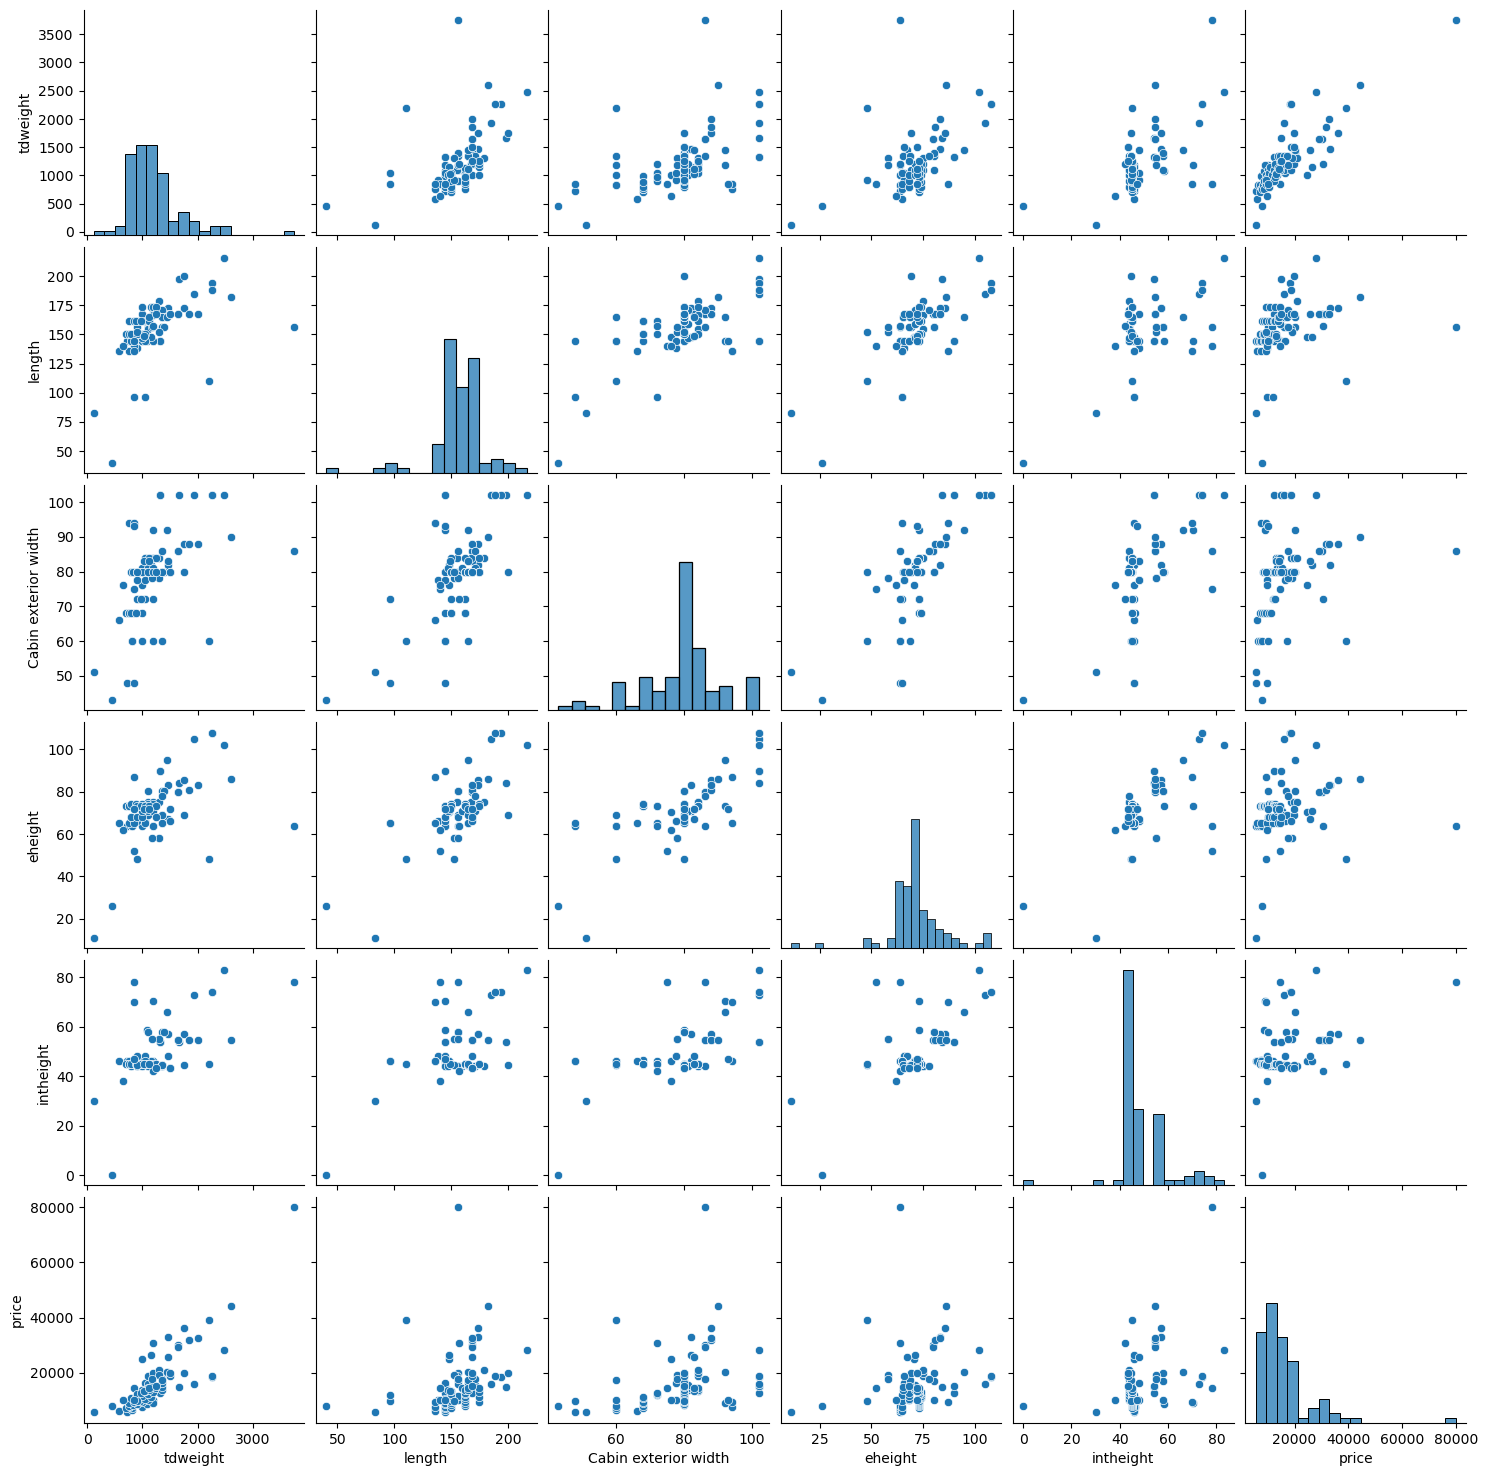

In [14]:
sns.pairplot(data)

Of all the variables, total dry weight appears to be the most correlated with the price. Let's look at it a bit more closely. 

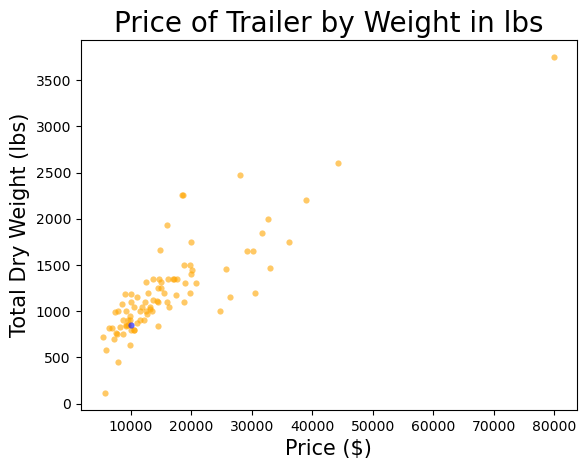

In [15]:
# values of x
x=data['price']
y= data['tdweight']

col = []
  
for i in range(0, len(x)):
    #the target trailer in blue
    if x[i]==9995:
        col.append('blue')  
    #all other trailers in orange
    else:
        col.append('orange') 
  
for i in range(len(x)):
      
    # plotting the corresponding x with y 
    # and respective color
    plt.scatter(x[i], y[i], c = col[i], s = 20,
                linewidth = 0, alpha=0.6)
    plt.title("Price of Trailer by Weight in lbs", fontsize=20)
    plt.ylabel("Total Dry Weight (lbs)", fontsize=15)
    plt.xlabel("Price ($)", fontsize=15)
      
plt.show()

Now let's look at how a few features map onto the weight vs. price

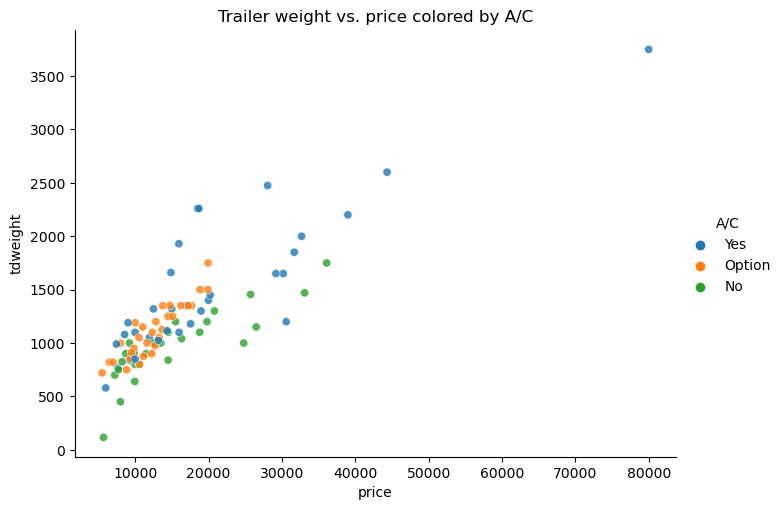

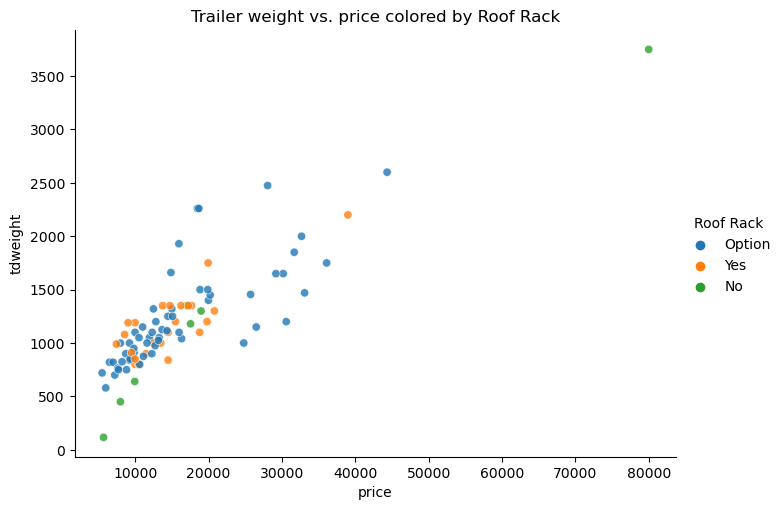

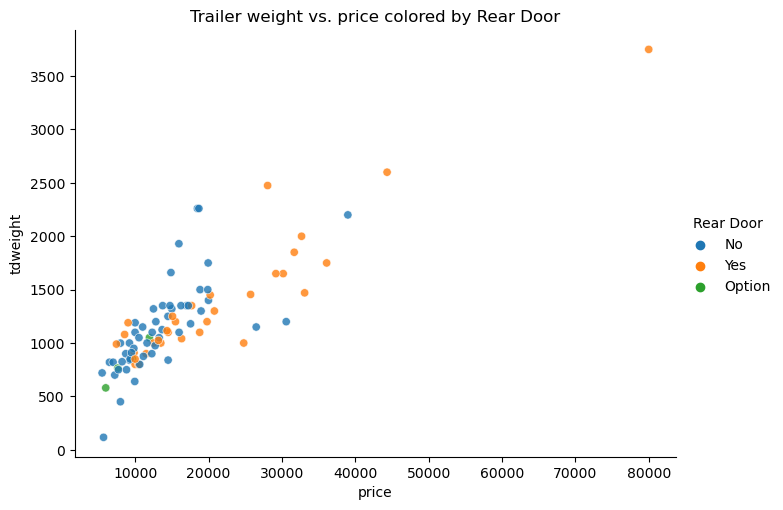

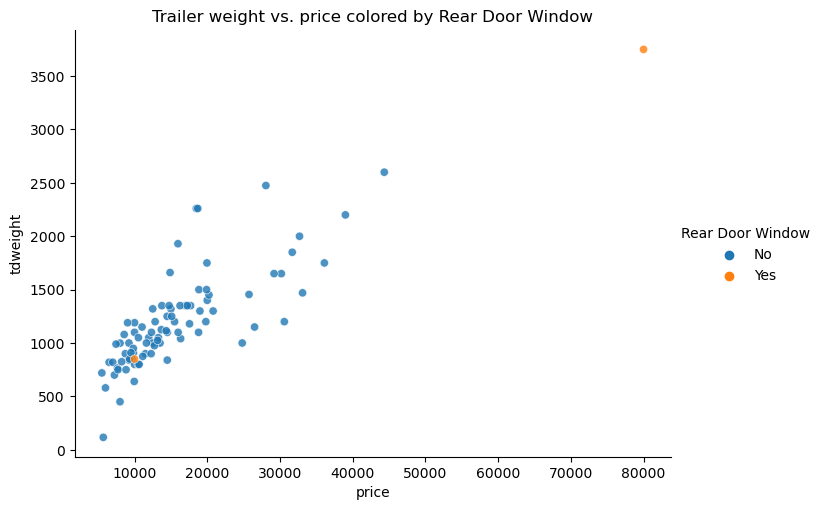

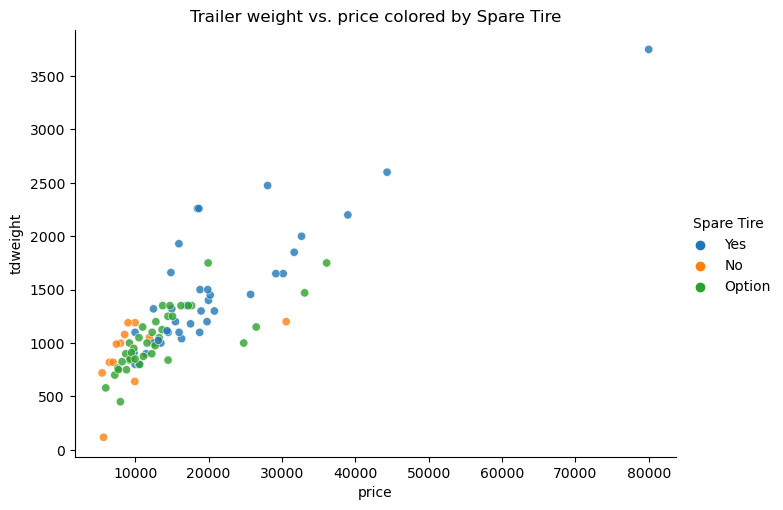

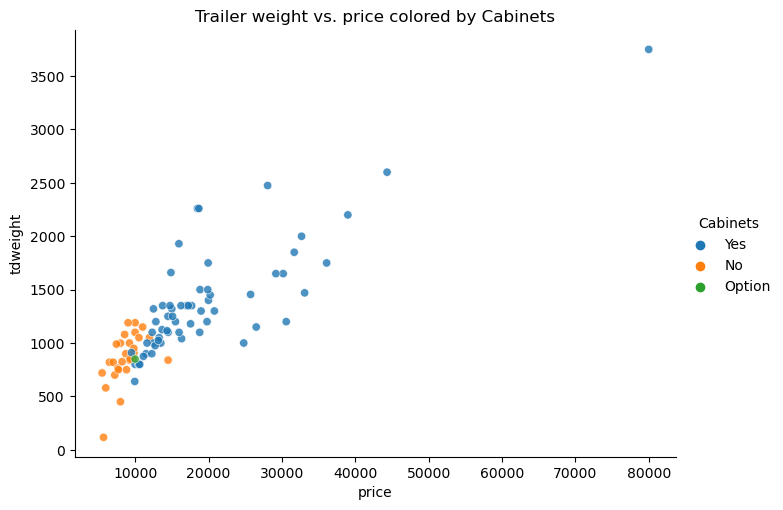

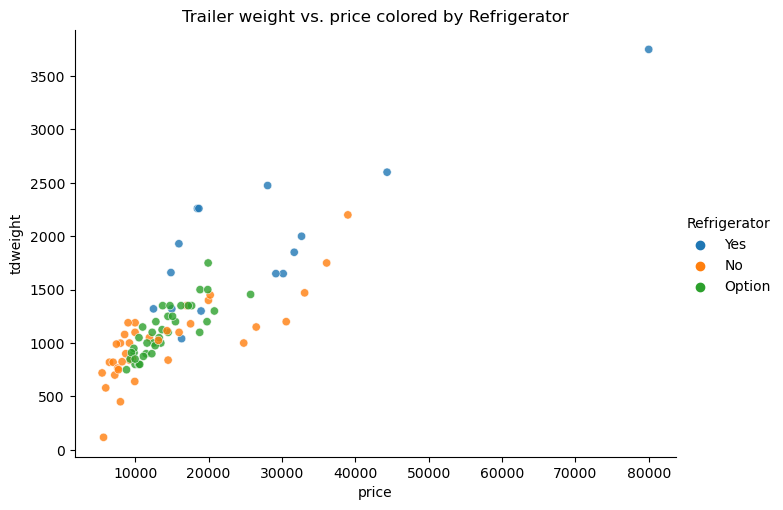

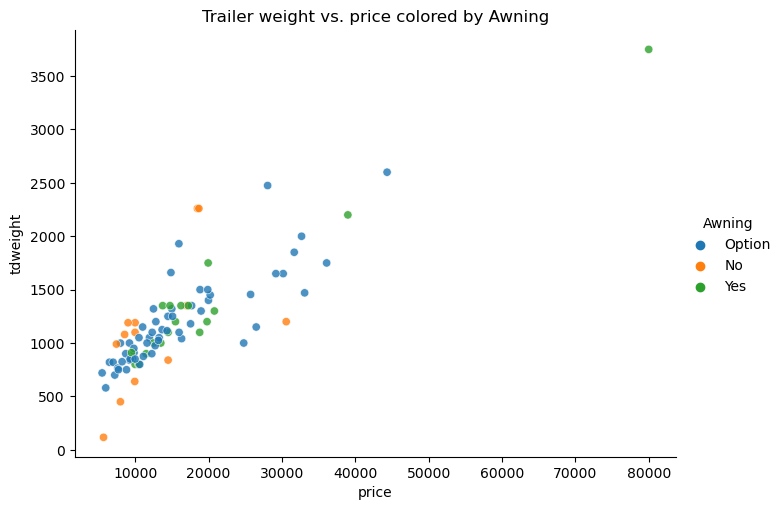

In [16]:
for c in ['A/C', 'Roof Rack', 'Rear Door', 'Rear Door Window', 'Spare Tire', 'Cabinets', 'Refrigerator', 'Awning']:
    sns.relplot(data=data, x='price', y='tdweight', hue=f"{c}", aspect=1.4, alpha=0.8)
    plt.title(f'Trailer weight vs. price colored by {c.title()}')
    plt.show()

In [17]:
#select the categorical data for encoding
cat_data = data.iloc[:, 5:21]
cat_data

,eheight,intheight,A/C,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Cabinets,Refrigerator,Awning
0,84.0,54.0,Yes,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option
1,108.0,74.0,Yes,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No
2,90.0,54.0,Yes,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option
3,90.0,54.0,Yes,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option
4,105.0,73.0,Yes,Option,Yes,No,No,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Option
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,102.0,83.0,Yes,Option,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Option
85,66.0,43.5,Option,Option,No,Yes,Yes,Yes,Yes,No,No,No,Yes,Yes,Option,Option
86,72.0,43.5,Option,Option,No,Yes,Yes,Yes,Yes,No,No,No,Yes,Yes,Option,Option
87,68.0,43.5,Option,Option,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Option,Yes,Option,Option


In [18]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

#label encode the data to prepare for modeling
#label encoding is preferred for categorical variables

for col in cat_data:
    data[col] = labelencoder.fit_transform(data[col])
 
data.head()

,Manufacturer,model,tdweight,length,Cabin exterior width,eheight,intheight,A/C,Roof Rack,Driver Side Window,...,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Cabinets,Refrigerator,Awning,price
0,Sunset Park RV,Sunray 109E,1660.0,198,102.0,26,12,2,1,2,...,1,2,1,0,0,2,2,2,1,14879
1,Sunset Park RV,Sunray 149,2260.0,194,102.0,34,22,2,1,2,...,1,2,1,0,0,2,2,2,0,18489
2,Sunset Park RV,Sunray Classic 109,1320.0,144,102.0,30,12,2,1,2,...,1,2,1,0,0,2,2,2,1,12500
3,Sunset Park RV,Sunray Classic 109,1320.0,144,102.0,30,12,2,1,2,...,1,2,1,0,0,2,2,2,1,14997
4,Sunset Park RV,Sunray Classic 129,1930.0,185,102.0,33,21,2,1,2,...,1,2,1,0,0,2,2,2,1,15965


In [19]:
#make a copy of the data for later
data2=data

In [20]:
corr=data2.corr()
corr

,tdweight,length,Cabin exterior width,eheight,intheight,A/C,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Cabinets,Refrigerator,Awning,price
tdweight,1.000000,0.521722,0.513825,0.393523,0.575681,0.421971,-0.049955,0.140993,-0.066809,-0.033965,0.018163,0.233647,0.136771,0.218212,0.324587,0.464564,0.473397,0.551897,0.138533,0.846531
length,0.521722,1.000000,0.625446,0.580298,0.309209,0.096455,0.189301,0.089443,0.216309,0.255002,0.443345,0.505262,0.137314,0.108635,-0.033899,0.388772,0.462235,0.475373,0.213313,0.279714
Cabin exterior width,0.513825,0.625446,1.000000,0.700374,0.517259,0.294213,0.088899,0.145035,-0.092218,-0.064295,0.373477,0.385248,0.266926,0.264449,0.131560,0.559650,0.454202,0.537305,0.071069,0.294207
eheight,0.393523,0.580298,0.700374,1.000000,0.492030,0.280425,0.003958,0.246772,-0.135084,-0.076346,0.393397,0.467636,0.327567,0.140639,-0.089797,0.394476,0.263360,0.407758,-0.115649,0.146918
intheight,0.575681,0.309209,0.517259,0.492030,1.000000,0.491077,-0.166090,0.310688,-0.344902,-0.356486,-0.076582,0.132449,0.283399,0.127650,0.205000,0.249136,0.014215,0.239072,-0.323766,0.382301
A/C,0.421971,0.096455,0.294213,0.280425,0.491077,1.000000,-0.207000,0.509894,-0.400447,-0.379940,0.144102,0.159161,0.458710,-0.078192,0.172379,0.079561,0.052091,0.186047,-0.292477,0.205827
Roof Rack,-0.049955,0.189301,0.088899,0.003958,-0.166090,-0.207000,1.000000,-0.359164,0.270082,0.172121,0.258216,-0.127869,-0.178480,0.318490,-0.051863,0.006432,0.084376,0.028288,0.481019,-0.148731
Driver Side Window,0.140993,0.089443,0.145035,0.246772,0.310688,0.509894,-0.359164,1.000000,-0.196820,-0.191959,0.126324,0.164623,0.821340,-0.023249,-0.046601,-0.005102,-0.080948,0.248740,-0.331210,-0.014573
Driver Side Door,-0.066809,0.216309,-0.092218,-0.135084,-0.344902,-0.400447,0.270082,-0.196820,1.000000,0.740666,0.374912,0.148364,-0.141158,0.162008,-0.268682,-0.124927,0.111552,0.048134,0.325758,0.023178
Driver Side Door Window,-0.033965,0.255002,-0.064295,-0.076346,-0.356486,-0.379940,0.172121,-0.191959,0.740666,1.000000,0.293620,0.461443,-0.110829,0.017714,-0.050170,-0.062490,0.188932,0.142626,0.260401,0.096079


<AxesSubplot:>

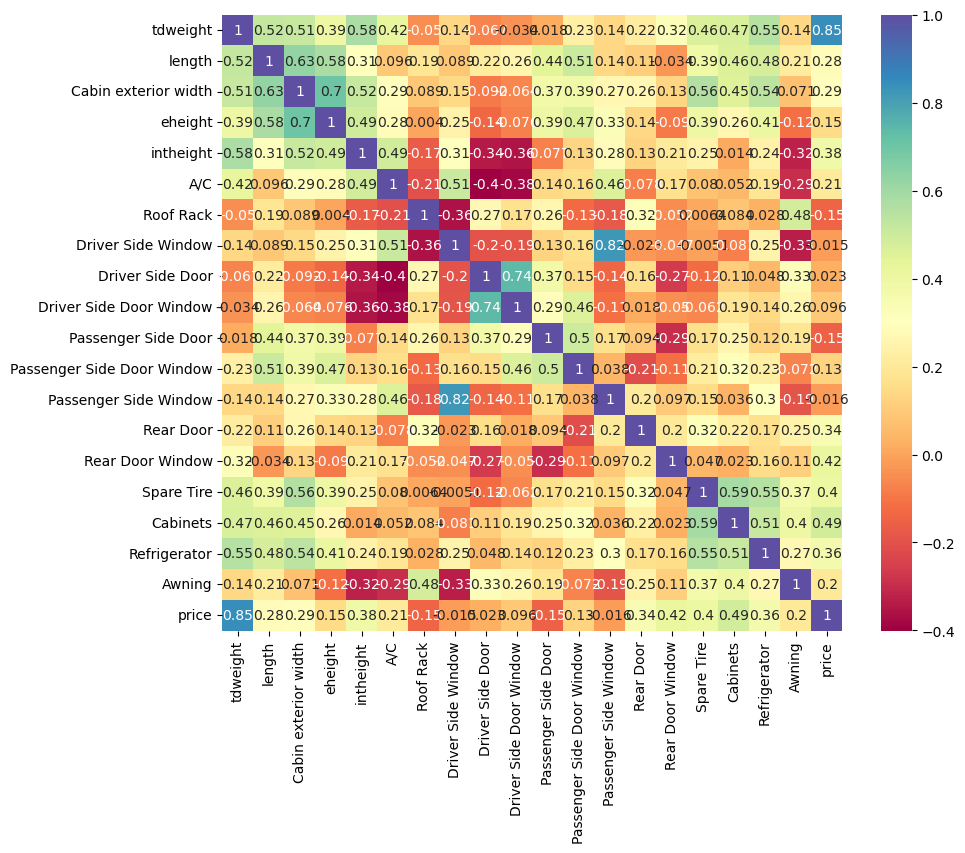

In [21]:
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True,cmap="Spectral")

# Machine Learning Modeling
The data is now clean and we can move forward with creating some machine learning models. Once we settle on the best model it can be used to predict the target price of the trailer in question.

#Replace "option" with "no" and try modeling again

In [22]:
data2=data2.drop(data.index[[88]])

In [23]:
#here the data is split up into X,y where X contains everything but price and y contains what we want to predict (price)
#price is what we want to predict
X = data2.drop(['price', 'Manufacturer', 'model'],axis=1)
y=data2['price']

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [25]:
#scaling the data
#this usually helps with modeling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
#function which runs different ML models and prints R^2, MAE and RMSE
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    #EVALUATION OF THE MODEL
    # Plotting y_test and y_pred to understand the spread.
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=16) 

Now the data is all cleaned up and ready for creating some machine learning models. A funtion has been written to run various models and output metrics 

R^2 :  0.7547110267383965
MAE : 2012.4079452164403
RMSE: 2505.8416895850055


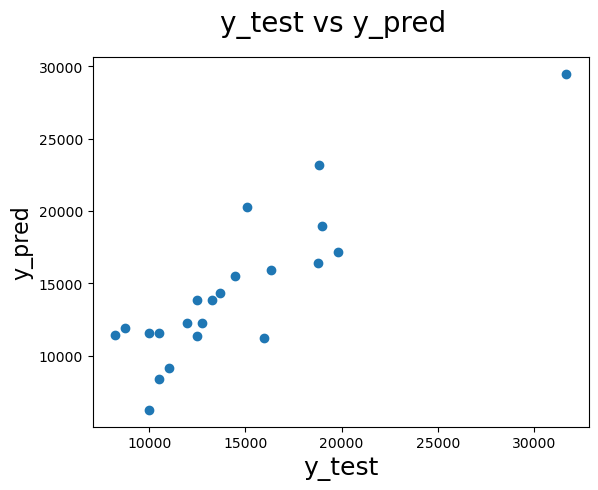

In [27]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  -0.20685575651404364
MAE : 3328.409090909091
RMSE: 5558.304061982804


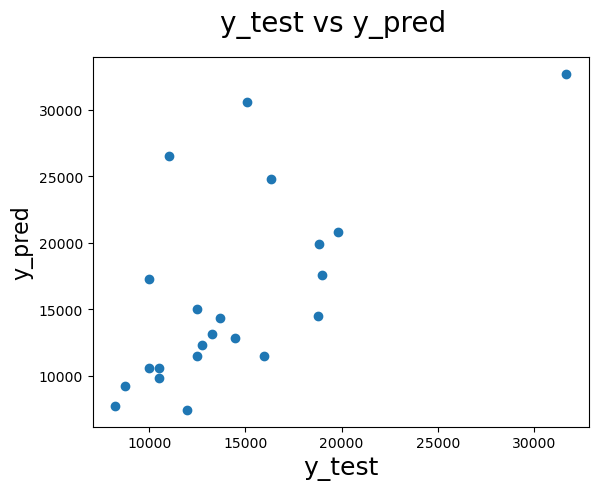

In [28]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.5023143272036481
MAE : 3059.541849171158
RMSE: 3569.375077456588


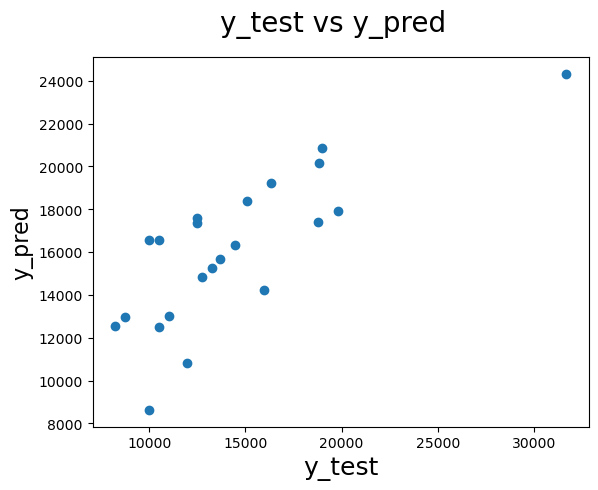

In [29]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.7065541535139723
MAE : 2373.236256297435
RMSE: 2740.8079227085877


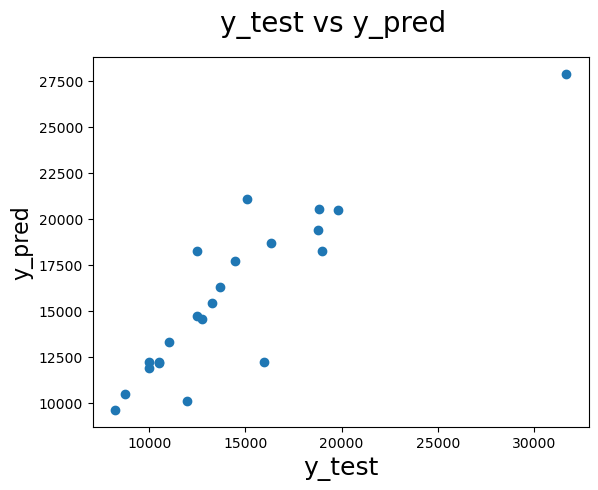

In [30]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.7493611814156351
MAE : 2034.7085125431074
RMSE: 2533.0209690829797


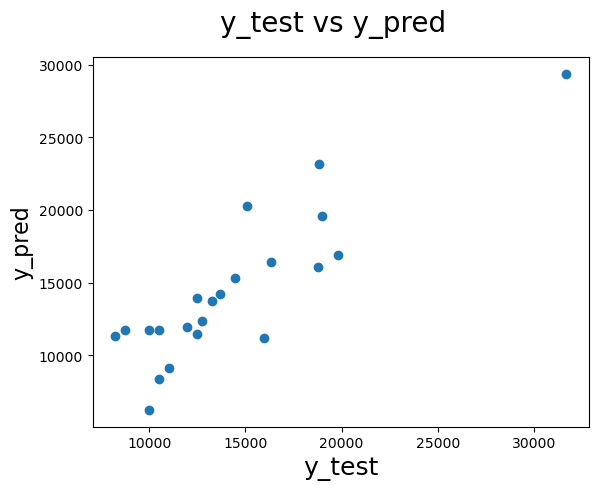

In [31]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.7547606683012504
MAE : 2011.179667240585
RMSE: 2505.5881107338546


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


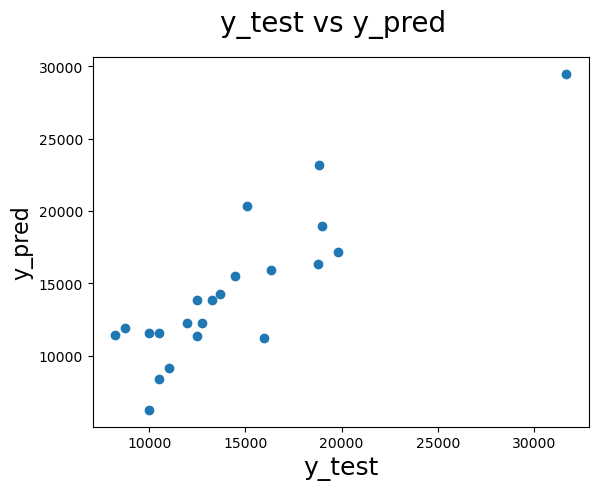

In [32]:
model_6 = LassoLars(alpha=.1)
run_experiment(model_6)

R^2 :  0.7320256762527275
MAE : 2183.900699514363
RMSE: 2619.155054114284


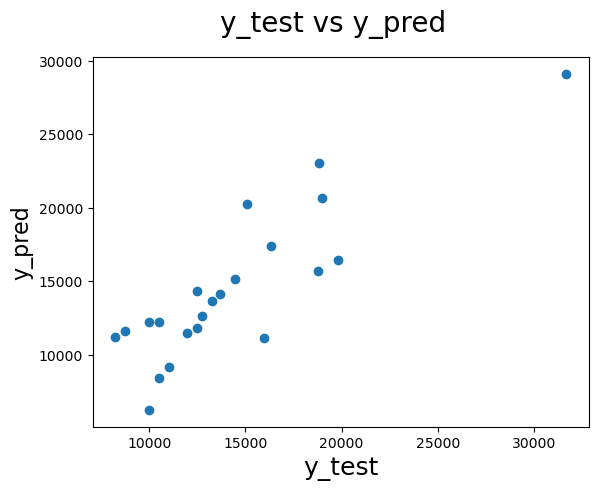

In [33]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.7366470785638488
MAE : 2099.775551605361
RMSE: 2596.472264690568


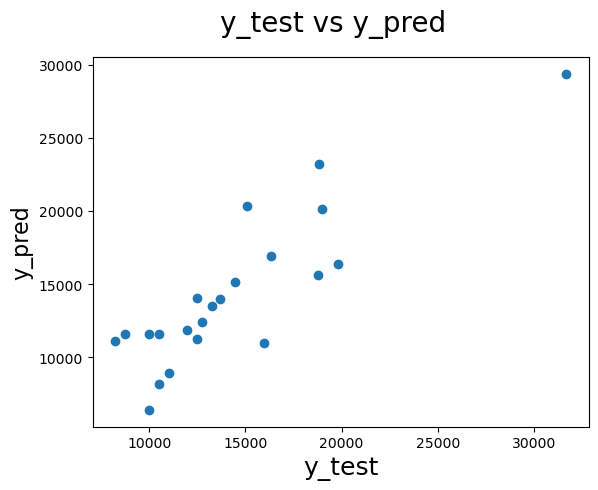

In [34]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.002687625636080604
MAE : 3661.4098376585853
RMSE: 5066.376321276427


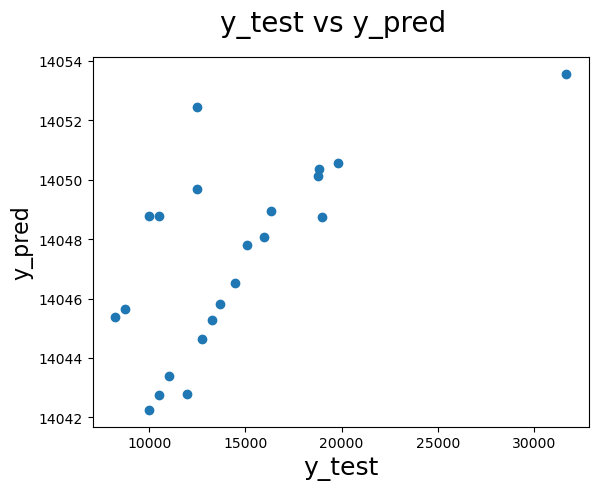

In [35]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.7929636730495523
MAE : 1843.9994233115385
RMSE: 2302.1726742408423


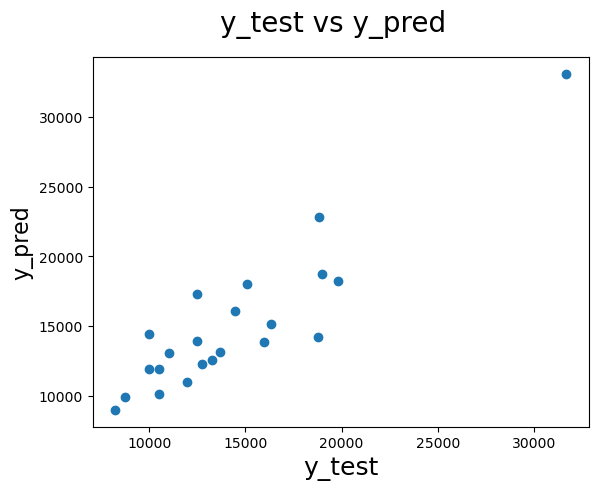

In [36]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

Unsurprisingly, RandomForest preformed better than all the other models tested. Therefore we will move forward with tuning hyperparameters to figure out which produce the best result.

# Checking Feature Importance

The features which have been included thus far are based on features that have enough data available online to realistically include, and picking out which ones are actually important is still in progress. Currently, a more novel feature information (e.g. solar panels) are being mined, while others whihc are already included need to be optimized. One feature which is currently in process of engineering is the number of doors and if they include windows. the information is currently held in 4 seperate columns which have low correlation to the price, and should be combined into a single column containing all of the information to improve calculations. 

In [37]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = data2.drop(['price', 'Manufacturer', 'model'],axis=1)
y=data2['price']
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#naming the columns
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(20,'Score'))  

                         Specs         Score
0                     tdweight  18672.404131
3                      eheight    345.652632
1                       length    314.674980
4                    intheight    267.209501
2         Cabin exterior width    158.764621
13                   Rear Door    102.000000
14            Rear Door Window     87.000000
17                Refrigerator     59.746269
7           Driver Side Window     58.704348
9      Driver Side Door Window     56.982456
16                    Cabinets     54.533333
5                          A/C     53.446809
8             Driver Side Door     40.686567
11  Passenger Side Door Window     33.517986
15                  Spare Tire     32.628319
18                      Awning     27.172043
12       Passenger Side Window     25.290323
6                    Roof Rack     22.923077
10         Passenger Side Door      5.000000


[0.19137051 0.16273217 0.11502441 0.11710286 0.05500797 0.03206695
 0.03395972 0.02187796 0.02227619 0.02724984 0.00839857 0.02412717
 0.0207702  0.03042391 0.00313361 0.03324358 0.03710772 0.03201126
 0.0321154 ]


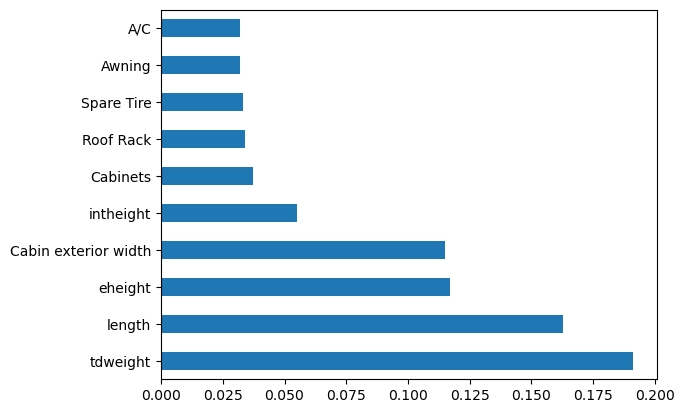

In [38]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

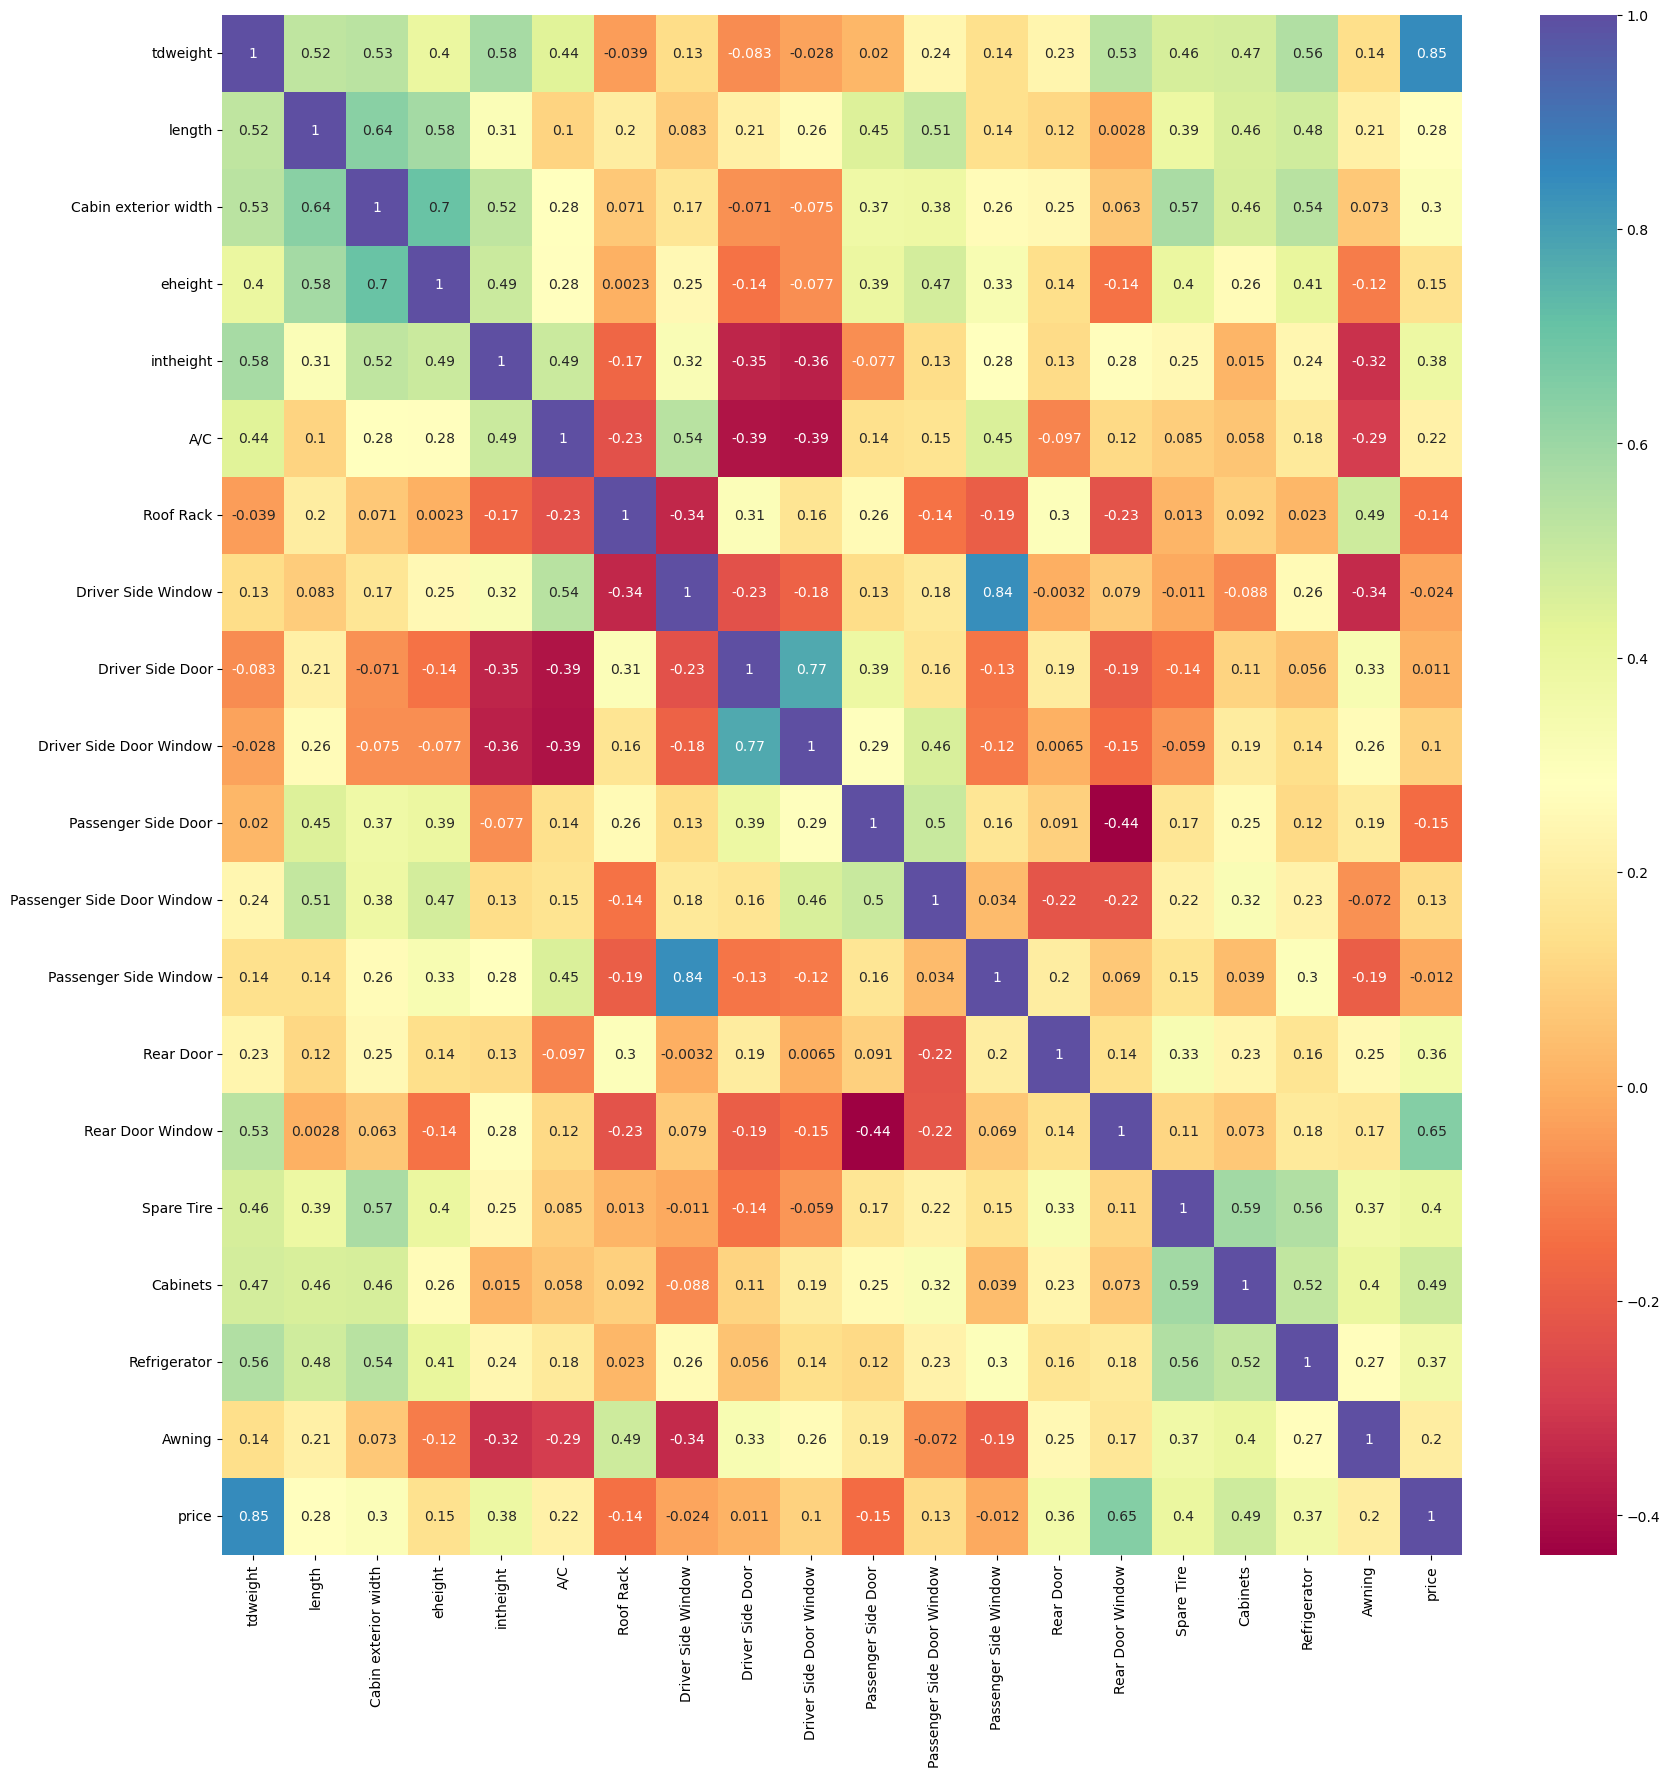

In [39]:
#get correlations of each features in dataset
corrmat = data2.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data2[top_corr_features].corr(),annot=True,cmap="Spectral")

# Feature Engineering
This section is in progress while more feature data is collected.

In [40]:
data3=data.drop(data.index[[88]])

In [41]:
#removing everything with a negative correlation
X = data3.drop(['price', 'Roof Rack', 'Driver Side Window', 'Driver Side Door', 'Passenger Side Door', 'Passenger Side Window', 'Manufacturer', 'model'],axis=1)
y=data3['price']

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [43]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    #EVALUATION OF THE MODEL
    # Plotting y_test and y_pred to understand the spread.
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=16) 

R^2 :  0.7669314828411856
MAE : 1922.549263271699
RMSE: 2442.6228989178467


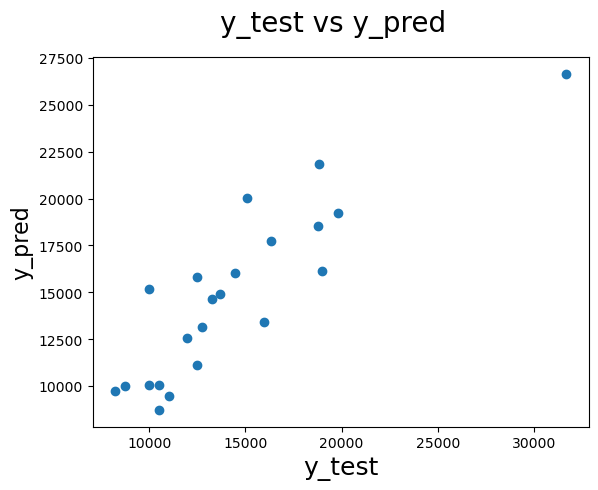

In [45]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  -0.1931548160935017
MAE : 3329.7272727272725
RMSE: 5526.663427092664


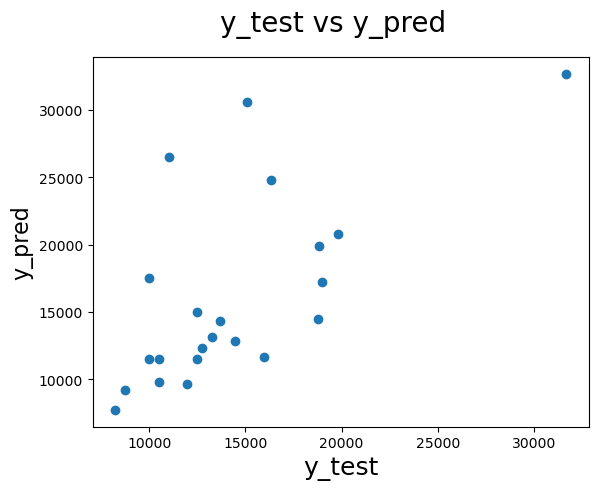

In [46]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.49211211778564234
MAE : 2890.7862517251506
RMSE: 3605.774334577552


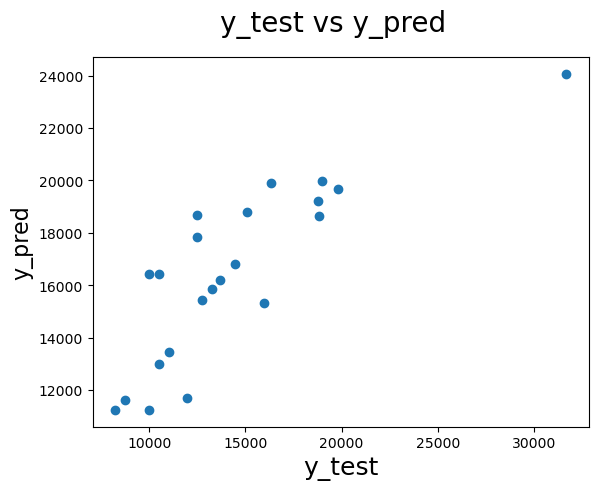

In [47]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.7065648702816196
MAE : 2373.1989207842958
RMSE: 2740.757874513656


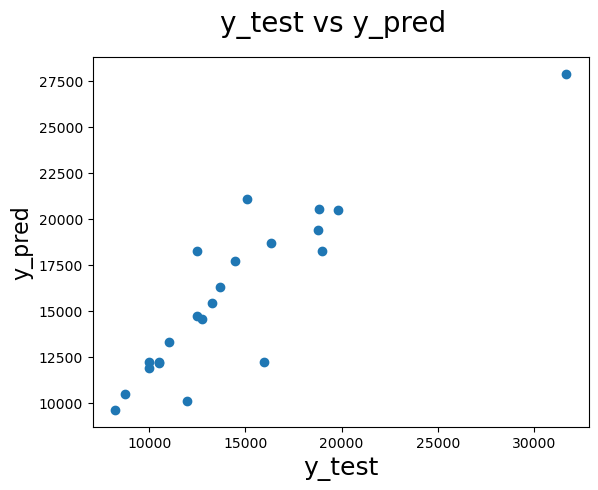

In [48]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.7762028455065334
MAE : 1881.6019319522952
RMSE: 2393.546658435317


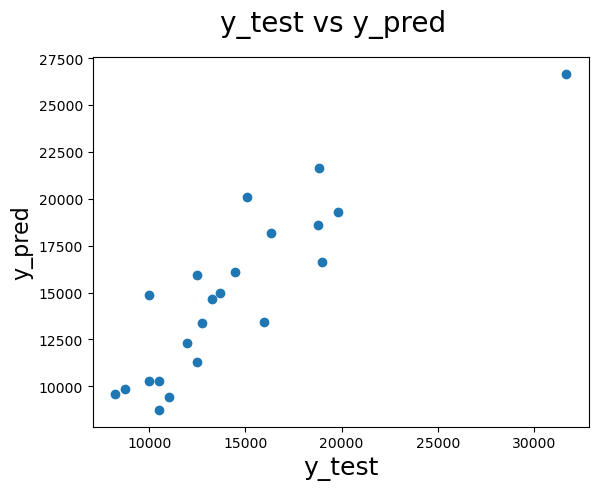

In [49]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.7855592283227307
MAE : 1838.963254889944
RMSE: 2342.978472758203


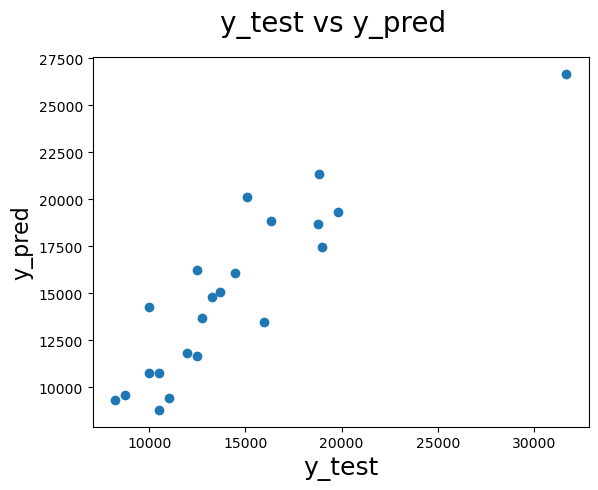

In [50]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.7789794064697139
MAE : 1878.0733481576654
RMSE: 2378.6524339612633


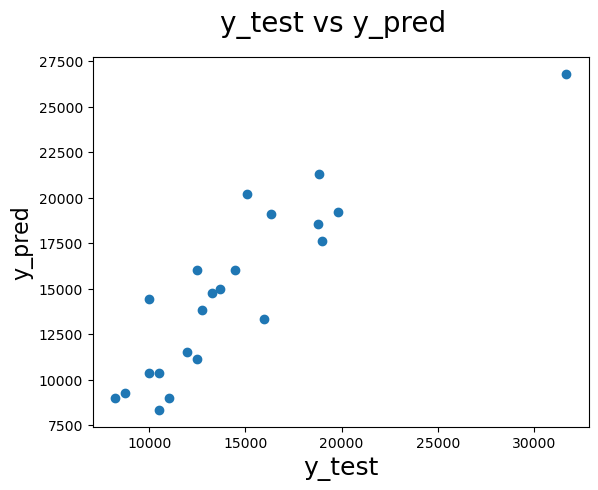

In [51]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.002356781444891709
MAE : 3660.8452215073994
RMSE: 5065.540408164846


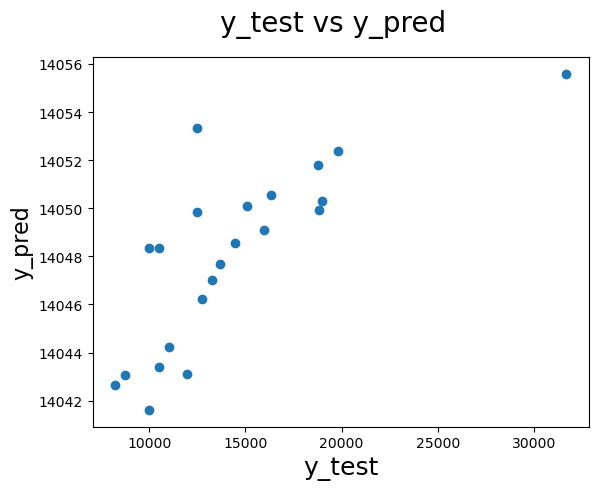

In [52]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.7893712292589992
MAE : 1796.6842083207207
RMSE: 2322.0601436834554


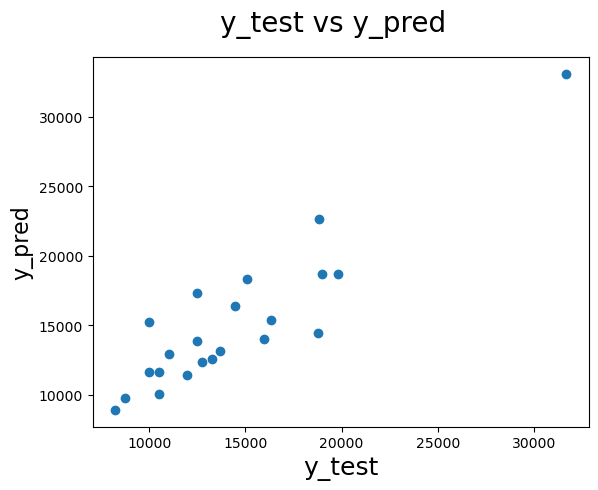

In [53]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

[0.20332988 0.16328904 0.12792638 0.13293075 0.06939577 0.03807276
 0.03559426 0.03410844 0.03628469 0.003739   0.03760014 0.035388
 0.03668154 0.04565935]


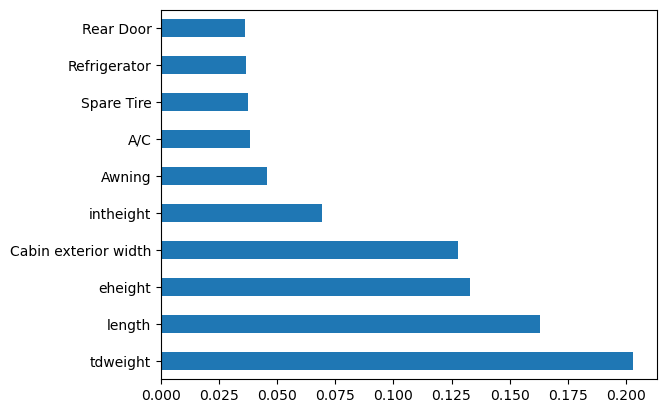

In [54]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## Hyperparameter Tuning
Perhaps it is a bit early to get into hyperparameter tuning, but nonetheless the code is ready for once the dataset has been expanded :) Commented out for time saving purposes.

In [55]:
rfc=RandomForestRegressor(random_state=1)

In [56]:
param_grid = { 
    'n_estimators': [100, 500, 1000, 5000],
    'max_features': ['auto', 'sqrt', 'log2'],
    #to save time in updating the notebook, max_depth is also left out
     'max_depth' : [5, 10, 15],
     'min_samples_leaf' : [1,2,3,5],
     #'criterion' :['squared_error', 'absolute_error', 'friedman_mse']
}


In [57]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 5],
                         'n_estimators': [100, 500, 1000, 5000]})

In [58]:
#print the best parameters determined in GridSearchCV
CV_rfc.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 100}

R^2 :  0.8167999936273748
MAE : 1576.0622370129868
RMSE: 2165.5955973833734


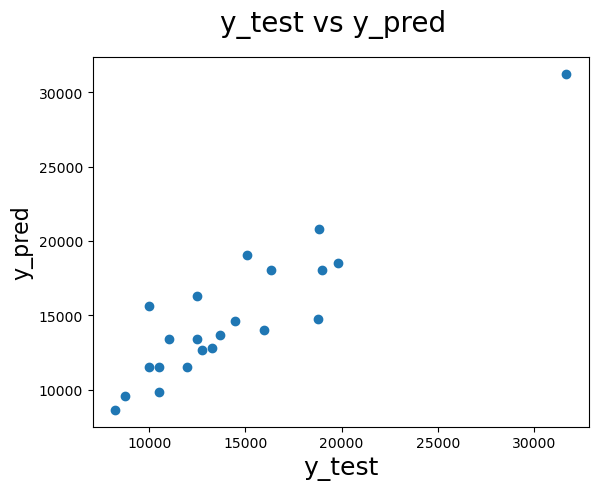

In [59]:
#run a final model using the optimal parameters
final_model = RandomForestRegressor(criterion= 'squared_error', n_estimators=100, max_features='auto', max_depth=10, min_samples_leaf=1, random_state=1)
run_experiment(final_model)

# Checking the value of interest

In [60]:
new_input = data.loc[88:89]
new_input

,Manufacturer,model,tdweight,length,Cabin exterior width,eheight,intheight,A/C,Roof Rack,Driver Side Window,...,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Spare Tire,Cabinets,Refrigerator,Awning,price
88,XYZ Camping,NaN,850.0,144,93.0,17,10,2,2,0,...,1,2,1,2,1,1,1,1,1,9995


In [61]:
#drop the variable to be predicted
new_input=new_input.drop(['price', 'Roof Rack', 'Driver Side Window', 'Driver Side Door', 'Passenger Side Door', 'Passenger Side Window', 'Manufacturer', 'model'],axis=1)
new_input

,tdweight,length,Cabin exterior width,eheight,intheight,A/C,Driver Side Door Window,Passenger Side Door Window,Rear Door,Rear Door Window,Spare Tire,Cabinets,Refrigerator,Awning
88,850.0,144,93.0,17,10,2,2,2,2,1,1,1,1,1


In [62]:
new_input_scaled = scaler.fit_transform(new_input)

In [63]:
new_output = final_model.predict(new_input_scaled)
new_output

array([15898.20733333])

# Notes on the metrics used
✔️ Regression Evaluation Metrics
Here are three common evaluation metrics for regression problems:

Mean Absolute Error (MAE) is the mean of the absolute value of the errors:
1𝑛∑𝑖=1𝑛|𝑦𝑖−𝑦̂𝑖|
1
n
∑
i
=
1
n
|
y
i
−
y
^
i
|
 

 
Mean Squared Error (MSE) is the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2‾‾‾‾‾‾‾‾‾‾‾‾‾‾⎷
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
📌 Comparing these metrics:

MAE is the easiest to understand, because it's the average error.
MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.
All of these are loss functions, because we want to minimize them.

https://www.kaggle.com/code/faressayah/practical-introduction-to-10-regression-algorithm?scriptVersionId=117768677&cellId=36

<iframe src="https://www.kaggle.com/embed/faressayah/practical-introduction-to-10-regression-algorithm?cellIds=36&kernelSessionId=117768677" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Practical Introduction to 10 Regression Algorithm"></iframe>